# Ring Mark Decoder

## Code Definition

- Convention: '1' = there is a mark, '0' otherwise
- Start from external ring, then switch for the internal ring
- For each ring, start with angle=0, i.e. (x,y)=(1,0) on the unitary-circle

## Algorithm Overview

1. Load input image
- Load anchor image ("M" mark)
- Preprocessing: color-space-conversion
- Locate the anchor in a multi-scale Template-Matching scheme
- Extract ROI image (2-rings) based on the ancor location
- ROI binary thresholding
- Ring code decoding

External Ring:
[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]

Internal Ring:
[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]

Merged Code (Int+Ext):
10111011011011111010111111101111011011101101111101110111110110111011111011

Code = 0X2EDBEBFBDBB7DDF6EFB



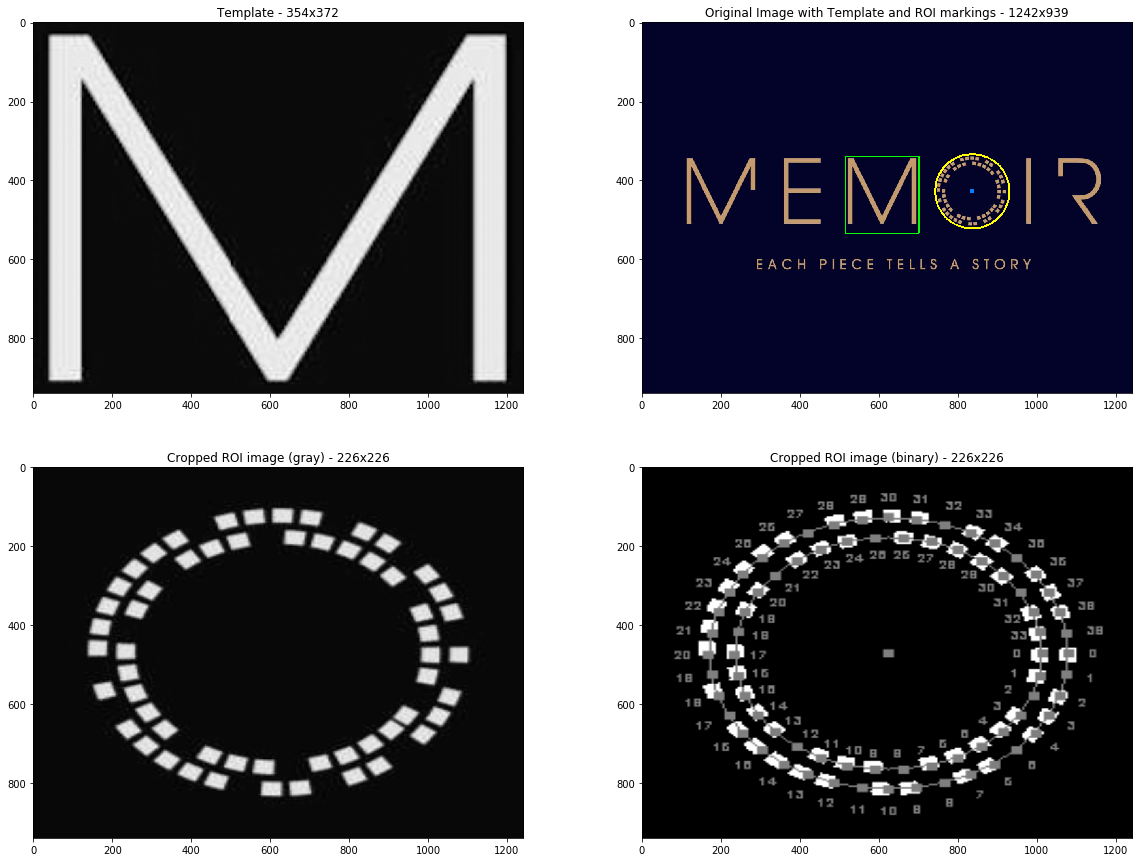

In [7]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

# User Parameters:
marks_num_external=40
marks_num_internal=34
template_matching_thr = 0.9
template_matching_min_scale = 0.4
template_matching_max_scale = 1.2
template_to_mark_x_scale = 1.72
template_to_mark_y_scale = 0.45
crop_margin_r = 1.2
crop_margin_x = 2
crop_margin_y = 0
roi_r1_scale = 0.88
roi_r2_scale = 0.75
mark_decode_thr = 128
debug_en = True

# Load image + Template:
img = cv2.imread('../data/image0.jpg')
template = cv2.imread('../templates/template_m.png')

# Color space conversions:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Dimensions extraction: 
w, h = img_gray.shape[::-1]
tw, th = template_gray.shape[:2]

# Template Matching, multi-scale, end up with ROI extraction (cropped):
crop_img = img_gray.copy()

for scale in np.linspace(template_matching_min_scale, template_matching_max_scale, 20)[::-1]:

    resized = imutils.resize(template_gray, width=int(tw*scale))
    r = template_gray.shape[1] / float(resized.shape[1])

    res = cv2.matchTemplate(img_gray, resized, cv2.TM_CCOEFF_NORMED)

    threshold = template_matching_thr
    loc = np.where( res >= threshold)
    if loc[0].any():
        
        pt = (int(np.median(loc[1])), int(np.median(loc[0])))
        
        x = pt[0] + int(np.ceil(template_to_mark_x_scale*tw*scale))
        y = pt[1] + int(np.ceil(template_to_mark_y_scale*th*scale))
        r = int(np.ceil(tw*scale/2))
        
        crop_img_gray = img_gray[y-int(np.ceil(crop_margin_r*r))-crop_margin_y:y+int(np.ceil(crop_margin_r*r)-crop_margin_y),
                                 x-int(np.ceil(crop_margin_r*r))-crop_margin_x:x+int(np.ceil(crop_margin_r*r))-crop_margin_x]
        
        _, crop_img_bw = cv2.threshold(crop_img_gray, 127, 255, cv2.THRESH_BINARY_INV)

        break


# Ring Marks extraction:
roi_x = int(np.ceil(crop_img_bw.shape[0]/2))
roi_y = int(np.ceil(crop_img_bw.shape[1]/2))
roi_r1 = int(np.ceil(roi_r1_scale*r))
roi_r2 = int(np.ceil(roi_r2_scale*r))    

mark_ext_list = []
for teta in np.linspace(0, 2*np.pi, marks_num_external+1):
    mark_ext_list.append((int(np.ceil(roi_x+roi_r1*np.cos(teta))), 
                          int(np.ceil(roi_y+roi_r1*np.sin(teta))),
                          int(np.ceil(roi_x+roi_r1*np.cos(teta)*1.15)), 
                          int(np.ceil(roi_y+roi_r1*np.sin(teta)*1.15))))

mark_int_list = []
for teta in np.linspace(0, 2*np.pi, marks_num_internal+1):        
    mark_int_list.append((int(np.ceil(roi_x+roi_r2*np.cos(teta))),
                          int(np.ceil(roi_y+roi_r2*np.sin(teta))),
                          int(np.ceil(roi_x+roi_r2*np.cos(teta)*0.85)),
                          int(np.ceil(roi_y+roi_r2*np.sin(teta)*0.85))))

# Ring code decoding:
mark_ext_val_list = []
for k,mark in enumerate(mark_ext_list[:-1]):
    mark_roi = crop_img_bw[mark[1]-2:mark[1]+2, mark[0]-2:mark[0]+2]
    mark_mean = cv2.mean(mark_roi)[0]
    mark_ext_val_list.append(int(mark_mean < mark_decode_thr))

mark_int_val_list = []
for k,mark in enumerate(mark_int_list[:-1]):
    mark_roi = crop_img_bw[mark[1]-2:mark[1]+2, mark[0]-2:mark[0]+2]
    mark_mean = cv2.mean(mark_roi)[0]
    mark_int_val_list.append(int(mark_mean < mark_decode_thr))

code_str = ""
for k in mark_ext_val_list + mark_int_val_list:
    code_str += str(k)
    
code = hex(int(code_str, 2)).upper()

print("External Ring:\n%s\n" % str(mark_ext_val_list))
print("Internal Ring:\n%s\n" % str(mark_int_val_list))
print("Merged Code (Int+Ext):\n%s\n" % code_str)
print("Code = %s\n" % code)

# Debug:
if debug_en:

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(img_rgb, pt, (pt[0] + int(tw*scale), pt[1] + int(th*scale)), (0,255,0), 2)             
    cv2.rectangle(img_rgb, (x-5, y-5), (x+5, y+5), (0, 128, 255), -1)    
    cv2.circle(img_rgb, (x, y), r, (255, 255, 0), 4)
    
    cv2.rectangle(crop_img_bw, (roi_x-2, roi_y-2), (roi_x+2, roi_y+2), 128, -1)
    cv2.circle(crop_img_bw, (roi_x, roi_y), roi_r1, 128, 1)
    cv2.circle(crop_img_bw, (roi_x, roi_y), roi_r2, 128, 1)
    
    for k,mark in enumerate(mark_ext_list[:-1]):
        cv2.rectangle(crop_img_bw, (mark[0]-2, mark[1]-2), (mark[0]+2, mark[1]+2), 128, -1)
        cv2.putText(crop_img_bw, str(k), (mark[2]-4, mark[3]+2), cv2.FONT_HERSHEY_SIMPLEX, 0.2, 128, 1)

    for k,mark in enumerate(mark_int_list[:-1]):
        cv2.rectangle(crop_img_bw, (mark[0]-2, mark[1]-2), (mark[0]+2, mark[1]+2), 128, -1)
        cv2.putText(crop_img_bw, str(k), (mark[2]-4, mark[3]+2), cv2.FONT_HERSHEY_SIMPLEX, 0.2, 128, 1) 
    
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    ax[0][0].imshow(cv2.resize(template_gray, (w,h)), cmap='gray')
    ax[0][1].imshow(img_rgb)
    ax[1][0].imshow(cv2.resize(crop_img_gray, (w,h)), cmap='gray')
    ax[1][1].imshow(cv2.resize(crop_img_bw, (w,h)), cmap='binary')
    ax[0][0].set_title('Template - %dx%d' % (tw, th))
    ax[0][1].set_title('Original Image with Template and ROI markings - %dx%d' % (w, h))
    ax[1][0].set_title('Cropped ROI image (gray) - %dx%d' % (crop_img_gray.shape[0], crop_img_gray.shape[1]))
    ax[1][1].set_title('Cropped ROI image (binary) - %dx%d' % (crop_img_bw.shape[0], crop_img_bw.shape[1]))
    plt.show()

In [15]:
print('Done!')

Done!
